In [1]:
from sklearn.datasets import load_iris

import torch
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.engine import Events
from ignite.metrics import Accuracy

from torch.utils.data import Dataset, DataLoader

%pylab inline
figsize(15, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dict = load_iris()

data = data_dict["data"]
target = data_dict["target"]

del data_dict

In [3]:
class Data(Dataset):
    def __init__(self, data, target):
        self.x = torch.FloatTensor(data)
        self.y = torch.LongTensor(target)
        self._len = target.size
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return self._len

In [4]:
data_obj = Data(data, target)
dataset = DataLoader(data_obj, shuffle=True, batch_size=50)

In [5]:
class Model(torch.nn.Module):
    def __init__(self, inpt, out):
        super(Model, self).__init__()
        self.l0 = torch.nn.Linear(inpt, 50)
        self.l1 = torch.nn.Linear(50, 150)
        self.l2 = torch.nn.Linear(150, 50)
        self.l3 = torch.nn.Linear(50, out)
        
    def forward(self, x):
        x = torch.relu(self.l0(x))
        x = torch.tanh(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return x

model = Model(4, 3)

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)

In [7]:
trainer = create_supervised_trainer(
    model, optimizer, criterion
)
evaluator = create_supervised_evaluator(
    model,
    metrics={"accuracy": Accuracy()}
)

In [8]:
@trainer.on(Events.EPOCH_COMPLETED)
def validate(trainer):
    if trainer.state.epoch % 100 == 0:
        evaluator.run(dataset)
        metrics = evaluator.state.metrics
        print(f"epoch: {trainer.state.epoch:<4} | " + \
              f"accuracy: {metrics['accuracy']:.2f} | " + \
              f"loss: {trainer.state.output:.2f}")

In [9]:
@trainer.on(Events.STARTED)
def init_log(trainer):
    trainer._losses = []
    trainer._accuracy = []

@trainer.on(Events.EPOCH_COMPLETED)
def save_log(trainer):
    evaluator.run(dataset)
    trainer._losses.append(
        trainer.state.output
    )
    trainer._accuracy.append(
        evaluator.state.metrics["accuracy"]
    )

In [10]:
state = trainer.run(dataset, max_epochs=1500)

epoch: 100  | accuracy: 0.33 | loss: 1.04
epoch: 200  | accuracy: 0.67 | loss: 0.98
epoch: 300  | accuracy: 0.67 | loss: 0.90
epoch: 400  | accuracy: 0.67 | loss: 0.81
epoch: 500  | accuracy: 0.67 | loss: 0.70
epoch: 600  | accuracy: 0.70 | loss: 0.64
epoch: 700  | accuracy: 0.77 | loss: 0.55
epoch: 800  | accuracy: 0.85 | loss: 0.46
epoch: 900  | accuracy: 0.89 | loss: 0.43
epoch: 1000 | accuracy: 0.93 | loss: 0.43
epoch: 1100 | accuracy: 0.94 | loss: 0.38
epoch: 1200 | accuracy: 0.97 | loss: 0.37
epoch: 1300 | accuracy: 0.97 | loss: 0.33
epoch: 1400 | accuracy: 0.97 | loss: 0.29
epoch: 1500 | accuracy: 0.98 | loss: 0.29


In [11]:
evaluator.state.metrics

{'accuracy': 0.98}

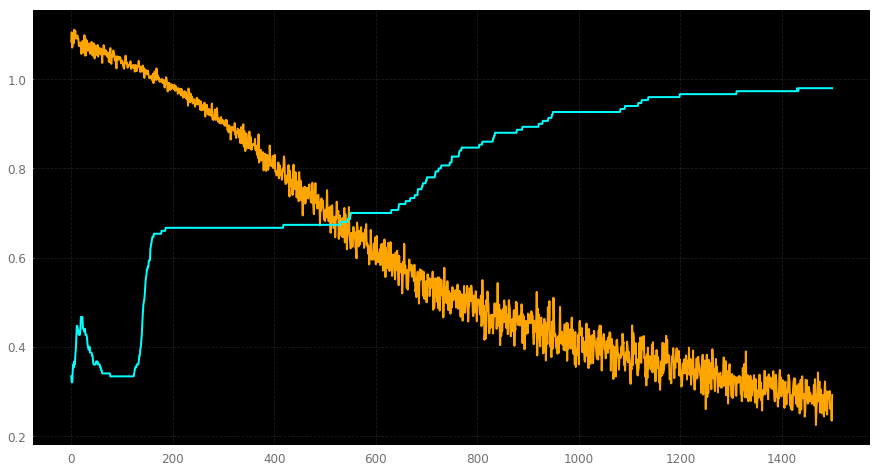

In [12]:
figsize(15, 8)
plot(trainer._losses, c="orange")
plot(trainer._accuracy, c="cyan")